In [51]:
import os

import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import numpy as np
from PIL import Image

%load_ext autoreload

%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dataset_file = pd.read_csv("../data/final_dataset.csv")
dataset_file.head()

,sequence,image_sequence,file,label,site,date,camera,sequence_image_count,has_animal,set
0,2,image1,290716114012001a1116.JPG,BIRD,001a,7/29/2016 11:40,111,3,1,train
1,12,image1,100816090812001a1111.JPG,BIRD,001a,8/10/2016 9:08,111,3,1,train
2,17,image1,180516121622001a1602.JPG,BIRD,001a,5/18/2016 12:16,160,3,1,train
3,18,image1,260416120224001a1601.JPG,BIRD,001a,4/26/2016 12:02,160,3,1,train
4,20,image1,160516023810001a1606.JPG,CAT,001a,5/16/2016 2:38,160,3,1,test


In [63]:
train_subset = dataset_file[dataset_file.set == 'train']

In [96]:
cam_loc_1 = train_subset[((train_subset.camera == '111') & (train_subset.site=='001a'))]

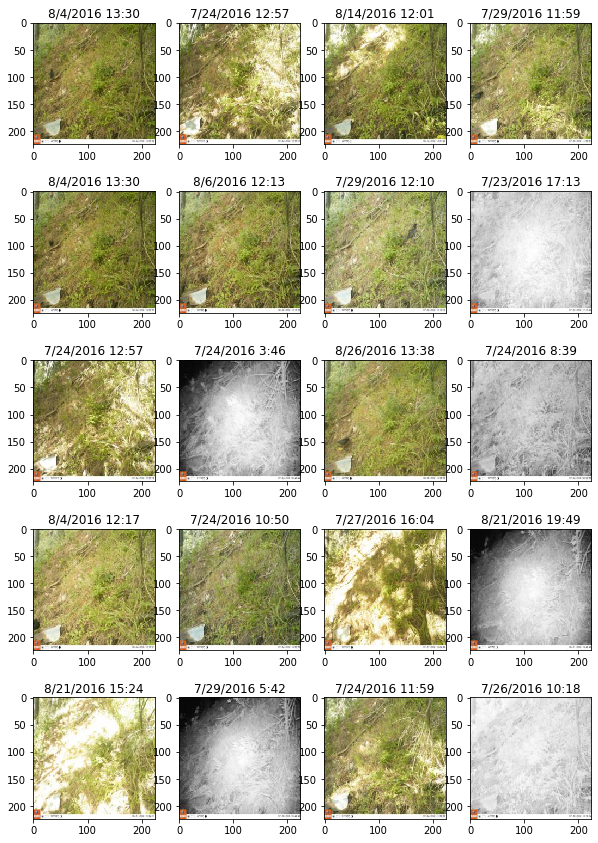

In [98]:
plt.figure(figsize=(10, 15))
for idx, filename in cam_loc_1.sample(20).reset_index(drop=True).iterrows():
    ax = plt.subplot(5, 4, idx + 1)
    plt.imshow(imread(os.path.join('../data/images/images-resized', filename.file)))
    plt.title(filename.date)

In [90]:
dataset_file.groupby(['site', 'camera']).count()//3

sequence  image_sequence  file  label  date  \
site camera                                                
001a 111          137             137   137    137   137   
     160           55              55    55     55    55   
     s07           65              65    65     65    65   
     s46          132             132   132    132   132   
001b 923           77              77    77     77    77   
...               ...             ...   ...    ...   ...   
956  590          173             173   173    173   173   
     L17          133             133   133    133   133   
985  330          119             119   119    119   119   
     S18          119             119   119    119   119   
     S35           45              45    45     45    45   

             sequence_image_count  has_animal  set  
site camera                                         
001a 111                      137         137  137  
     160                       55          55   55  
     s07                       65          65   65  
     s46                      132         132  132  
001b 923                       77          77   77  
...                           ...         ...  ...  
956  590                      173         173  173  
     L17                      133         133  133  
985  330                      119         119  119  
     S18                      119         119  119  
     S35                       45          45   45  

[638 rows x 8 columns]